In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from neural_net import AlphaZeroChess
import joblib
from tqdm import tqdm
import numpy as np
import gc
import glob
import random
import matplotlib.pyplot as plt
device = torch.device("cuda:0")

## Iteration 0:

In [3]:
files = glob.glob('./training_data_k/iter_0/*.joblib')

states = []
policies = []
values = []

for f in files:
    s, p, v = joblib.load(f)
    states += [s]
    policies += [p]
    values += [v]

total_rows = sum([v.shape[0] for v in values])
print('Total rows needed:', total_rows)

N = total_rows
torch_states = torch.zeros((N, 14, 8, 8), dtype=torch.float32, device=device)
torch_policies = torch.zeros((N, 4096), dtype=torch.float32, device=device)
torch_values = torch.zeros((N), dtype=torch.float32, device=device)

ind = 0
for i in tqdm(range(len(values))):
    s = states[i]
    p = policies[i]
    v = values[i]

    for j in range(v.shape[0]):
        k = ind + j
        torch_states[k] = torch.tensor(s[j].reshape((14, 8, 8)))
        torch_policies[k] = torch.tensor(p[j].reshape(4096))
        torch_values[k] = v[j]
    
    ind += v.shape[0]

100%|██████████| 766/766 [00:12<00:00, 59.62it/s]


In [4]:
torch.unique(torch_values, return_counts=True)

(tensor([-1.,  1.], device='cuda:0'), tensor([11935, 12331], device='cuda:0'))

In [5]:
model = AlphaZeroChess()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
epoch = 0
loss_per_epoch = []
model.train()

AlphaZeroChess(
  (conv): Conv2d(14, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res): Residual(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (policy_head): PolicyHead(
    (conv): Conv2d(256, 100, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc): Linear(in_features=6400, out_features=4096, bias=True)
    (softmax): Softmax(dim=1)
  )
  (value_head): ValueHead(
    (conv): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (tanh): Tanh()
  )
)

In [6]:
train_ds = TensorDataset(torch_states, torch_policies, torch_values)
train_loader = DataLoader(train_ds, batch_size=80, shuffle=True)

In [7]:
# %%
for e in tqdm(range(epoch, epoch + 30)):
    # print('Crunching epoch #', str(e))
    running_loss = 0
    for state, policy, value in train_loader:
        optimizer.zero_grad()
        pi_pred, v_pred = model(state)
        pi_pred = pi_pred.view(-1, 4096)

            # Calculate loss
        v_error = (value.view(-1) - v_pred.view(-1)) ** 2
        pi_error = torch.sum(policy * torch.log(pi_pred + 1e-6), axis=1)
        loss = torch.mean((v_error - pi_error))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('{} -> Epoch loss:'.format(e), running_loss)
    loss_per_epoch.append(running_loss)

epoch += 30
# %%
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_per_epoch
}, 'k-az1.pt')

100%|██████████| 30/30 [15:19<00:00, 30.65s/it]29 -> Epoch loss: 835.8898136615753



Iteration #1

In [10]:
files = glob.glob('./training_data_k/iter_0/*.joblib')
files += glob.glob('./training_data_k/iter_1/*.joblib')

states = []
policies = []
values = []

for f in files:
    s, p, v = joblib.load(f)
    states += [s]
    policies += [p]
    values += [v]

total_rows = sum([v.shape[0] for v in values])
print('Total rows needed:', total_rows)

N = total_rows
torch_states = torch.zeros((N, 14, 8, 8), dtype=torch.float32, device=device)
torch_policies = torch.zeros((N, 4096), dtype=torch.float32, device=device)
torch_values = torch.zeros((N), dtype=torch.float32, device=device)

ind = 0
for i in tqdm(range(len(values))):
    s = states[i]
    p = policies[i]
    v = values[i]

    for j in range(v.shape[0]):
        k = ind + j
        torch_states[k] = torch.tensor(s[j].reshape((14, 8, 8)))
        torch_policies[k] = torch.tensor(p[j].reshape(4096))
        torch_values[k] = v[j]
    
    ind += v.shape[0]

train_ds = TensorDataset(torch_states, torch_policies, torch_values)
train_loader = DataLoader(train_ds, batch_size=80, shuffle=True)

100%|██████████| 1315/1315 [00:26<00:00, 48.99it/s]


In [11]:
checkpoint = torch.load('k-az1.pt', map_location=lambda device, loc: device)
model = AlphaZeroChess()
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_per_epoch = checkpoint['loss']
model.train()

AlphaZeroChess(
  (conv): Conv2d(14, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res): Residual(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (policy_head): PolicyHead(
    (conv): Conv2d(256, 100, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc): Linear(in_features=6400, out_features=4096, bias=True)
    (softmax): Softmax(dim=1)
  )
  (value_head): ValueHead(
    (conv): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (tanh): Tanh()
  )
)

In [12]:
# %%
for e in tqdm(range(epoch, epoch + 30)):
    # print('Crunching epoch #', str(e))
    running_loss = 0
    for state, policy, value in train_loader:
        optimizer.zero_grad()
        pi_pred, v_pred = model(state)
        pi_pred = pi_pred.view(-1, 4096)

            # Calculate loss
        v_error = (value.view(-1) - v_pred.view(-1)) ** 2
        pi_error = torch.sum(policy * torch.log(pi_pred + 1e-6), axis=1)
        loss = torch.mean((v_error - pi_error))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('{} -> Epoch loss:'.format(e), running_loss)
    loss_per_epoch.append(running_loss)

epoch += 30
# %%
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_per_epoch
}, 'k-az4.pt')

100%|██████████| 30/30 [27:33<00:00, 55.11s/it]59 -> Epoch loss: 1164.3511786460876



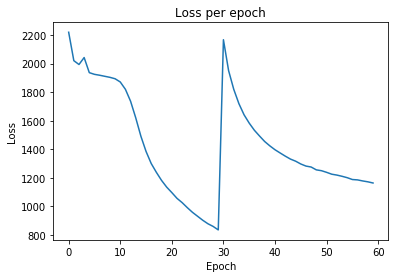

In [13]:
x = np.arange(len(loss_per_epoch))
plt.plot(x, loss_per_epoch)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Iteration #2

In [14]:
files = glob.glob('./training_data_k/iter_0/*.joblib')
files += glob.glob('./training_data_k/iter_1/*.joblib')
files += glob.glob('./training_data_k/iter_2/*.joblib')

states = []
policies = []
values = []

for f in files:
    s, p, v = joblib.load(f)
    states += [s]
    policies += [p]
    values += [v]

total_rows = sum([v.shape[0] for v in values])
print('Total rows needed:', total_rows)

N = total_rows
torch_states = torch.zeros((N, 14, 8, 8), dtype=torch.float32, device=device)
torch_policies = torch.zeros((N, 4096), dtype=torch.float32, device=device)
torch_values = torch.zeros((N), dtype=torch.float32, device=device)

ind = 0
for i in tqdm(range(len(values))):
    s = states[i]
    p = policies[i]
    v = values[i]

    for j in range(v.shape[0]):
        k = ind + j
        torch_states[k] = torch.tensor(s[j].reshape((14, 8, 8)))
        torch_policies[k] = torch.tensor(p[j].reshape(4096))
        torch_values[k] = v[j]
    
    ind += v.shape[0]

train_ds = TensorDataset(torch_states, torch_policies, torch_values)
train_loader = DataLoader(train_ds, batch_size=80, shuffle=True)

100%|██████████| 1853/1853 [00:37<00:00, 50.06it/s]


In [15]:
checkpoint = torch.load('k-az4.pt', map_location=lambda device, loc: device)
model = AlphaZeroChess()
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_per_epoch = checkpoint['loss']
model.train()

AlphaZeroChess(
  (conv): Conv2d(14, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res): Residual(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (policy_head): PolicyHead(
    (conv): Conv2d(256, 100, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc): Linear(in_features=6400, out_features=4096, bias=True)
    (softmax): Softmax(dim=1)
  )
  (value_head): ValueHead(
    (conv): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (tanh): Tanh()
  )
)

100%|██████████| 30/30 [37:35<00:00, 75.17s/it]89 -> Epoch loss: 1526.625816822052



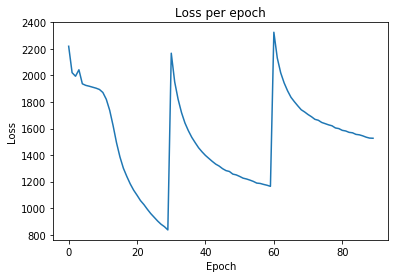

In [16]:
# %%
for e in tqdm(range(epoch, epoch + 30)):
    # print('Crunching epoch #', str(e))
    running_loss = 0
    for state, policy, value in train_loader:
        optimizer.zero_grad()
        pi_pred, v_pred = model(state)
        pi_pred = pi_pred.view(-1, 4096)

            # Calculate loss
        v_error = (value.view(-1) - v_pred.view(-1)) ** 2
        pi_error = torch.sum(policy * torch.log(pi_pred + 1e-6), axis=1)
        loss = torch.mean((v_error - pi_error))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('{} -> Epoch loss:'.format(e), running_loss)
    loss_per_epoch.append(running_loss)

epoch += 30
# %%
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_per_epoch
}, 'k-az7.pt')

x = np.arange(len(loss_per_epoch))
plt.plot(x, loss_per_epoch)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Iteration 3:

In [17]:
files = glob.glob('./training_data_k/iter_0/*.joblib')
files += glob.glob('./training_data_k/iter_1/*.joblib')
files += glob.glob('./training_data_k/iter_2/*.joblib')
files += glob.glob('./training_data_k/iter_3/*.joblib')

states = []
policies = []
values = []

for f in files:
    s, p, v = joblib.load(f)
    states += [s]
    policies += [p]
    values += [v]

total_rows = sum([v.shape[0] for v in values])
print('Total rows needed:', total_rows)

N = total_rows
torch_states = torch.zeros((N, 14, 8, 8), dtype=torch.float32, device=device)
torch_policies = torch.zeros((N, 4096), dtype=torch.float32, device=device)
torch_values = torch.zeros((N), dtype=torch.float32, device=device)

ind = 0
for i in tqdm(range(len(values))):
    s = states[i]
    p = policies[i]
    v = values[i]

    for j in range(v.shape[0]):
        k = ind + j
        torch_states[k] = torch.tensor(s[j].reshape((14, 8, 8)))
        torch_policies[k] = torch.tensor(p[j].reshape(4096))
        torch_values[k] = v[j]
    
    ind += v.shape[0]

train_ds = TensorDataset(torch_states, torch_policies, torch_values)
train_loader = DataLoader(train_ds, batch_size=80, shuffle=True)

100%|██████████| 2457/2457 [00:51<00:00, 47.72it/s]


In [18]:
checkpoint = torch.load('k-az7.pt', map_location=lambda device, loc: device)
model = AlphaZeroChess()
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_per_epoch = checkpoint['loss']
model.train()

AlphaZeroChess(
  (conv): Conv2d(14, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res): Residual(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (policy_head): PolicyHead(
    (conv): Conv2d(256, 100, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc): Linear(in_features=6400, out_features=4096, bias=True)
    (softmax): Softmax(dim=1)
  )
  (value_head): ValueHead(
    (conv): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (tanh): Tanh()
  )
)

100%|██████████| 30/30 [50:04<00:00, 100.13s/it]119 -> Epoch loss: 2420.4291404485703



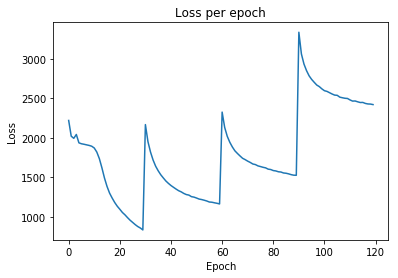

In [19]:
# %%
for e in tqdm(range(epoch, epoch + 30)):
    # print('Crunching epoch #', str(e))
    running_loss = 0
    for state, policy, value in train_loader:
        optimizer.zero_grad()
        pi_pred, v_pred = model(state)
        pi_pred = pi_pred.view(-1, 4096)

            # Calculate loss
        v_error = (value.view(-1) - v_pred.view(-1)) ** 2
        pi_error = torch.sum(policy * torch.log(pi_pred + 1e-6), axis=1)
        loss = torch.mean((v_error - pi_error))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('{} -> Epoch loss:'.format(e), running_loss)
    loss_per_epoch.append(running_loss)

epoch += 30
# %%
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_per_epoch
}, 'k-az10-0.pt')

x = np.arange(len(loss_per_epoch))
plt.plot(x, loss_per_epoch)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [21]:
files = glob.glob('./training_data_k/iter_0/*.joblib')
files += glob.glob('./training_data_k/iter_1/*.joblib')
files += glob.glob('./training_data_k/iter_2/*.joblib')
files += glob.glob('./training_data_k/iter_3/*.joblib')
files += glob.glob('./training_data_k/iter_4/*.joblib')

states = []
policies = []
values = []

for f in files:
    s, p, v = joblib.load(f)
    states += [s]
    policies += [p]
    values += [v]

total_rows = sum([v.shape[0] for v in values])
print('Total rows needed:', total_rows)

N = total_rows
torch_states = torch.zeros((N, 14, 8, 8), dtype=torch.float32, device=device)
torch_policies = torch.zeros((N, 4096), dtype=torch.float32, device=device)
torch_values = torch.zeros((N), dtype=torch.float32, device=device)

ind = 0
for i in tqdm(range(len(values))):
    s = states[i]
    p = policies[i]
    v = values[i]

    for j in range(v.shape[0]):
        k = ind + j
        torch_states[k] = torch.tensor(s[j].reshape((14, 8, 8)))
        torch_policies[k] = torch.tensor(p[j].reshape(4096))
        torch_values[k] = v[j]
    
    ind += v.shape[0]

train_ds = TensorDataset(torch_states, torch_policies, torch_values)
train_loader = DataLoader(train_ds, batch_size=80, shuffle=True)

100%|██████████| 3027/3027 [01:10<00:00, 43.03it/s]


In [22]:
checkpoint = torch.load('k-az10-0.pt', map_location=lambda device, loc: device)
model = AlphaZeroChess()
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_per_epoch = checkpoint['loss']
model.train()

AlphaZeroChess(
  (conv): Conv2d(14, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res): Residual(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (policy_head): PolicyHead(
    (conv): Conv2d(256, 100, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc): Linear(in_features=6400, out_features=4096, bias=True)
    (softmax): Softmax(dim=1)
  )
  (value_head): ValueHead(
    (conv): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (tanh): Tanh()
  )
)

100%|██████████| 30/30 [1:03:13<00:00, 126.44s/it]149 -> Epoch loss: 3127.080353975296



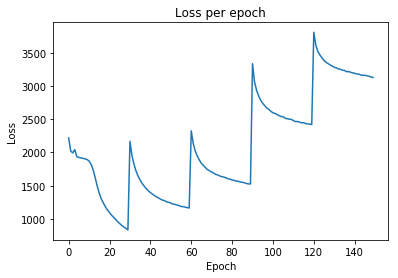

In [23]:
# %%
for e in tqdm(range(epoch, epoch + 30)):
    # print('Crunching epoch #', str(e))
    running_loss = 0
    for state, policy, value in train_loader:
        optimizer.zero_grad()
        pi_pred, v_pred = model(state)
        pi_pred = pi_pred.view(-1, 4096)

            # Calculate loss
        v_error = (value.view(-1) - v_pred.view(-1)) ** 2
        pi_error = torch.sum(policy * torch.log(pi_pred + 1e-6), axis=1)
        loss = torch.mean((v_error - pi_error))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('{} -> Epoch loss:'.format(e), running_loss)
    loss_per_epoch.append(running_loss)

epoch += 30
# %%
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_per_epoch
}, 'k-az10-1.pt')

x = np.arange(len(loss_per_epoch))
plt.plot(x, loss_per_epoch)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()